# Convolutional networks
This file shows how to programm and setup a convolutional neural network using Tensorflow.
Steps to do:
	- download and import data
    - preprocess data (structure data into training, validation, test set etc)
    - create mini-batches of data for training
    - setup or import a neural network model (tf.Graph)
    - define loss function
    - train neural network
    - evaluate neural network
    - provide an inference function for predicting labels of test data set (unknown data)
    - visualize neural network data with tensorflow and here in jupyter notebook

In [1]:
# import os   
import sys
sys.path.append('./util')
import pandas as pd
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import input_queues as iq
import plot_helpers as plt_help

In [2]:
m_height = 13  # multiplicate of image height size -> network is designed so 
    # that it can take images with shape of multiples of m
m_width = m_height  # multiplicate of image width size -> network 
    # is designed so that it can take images with shape of multiples of m
IMAGE_SHAPE = [32 * m_height, 32 * m_width, 3]  # complete image size 
    # [436, 1024, 3] # Narihira2015 use [M*32=13*32=416, 416, 3]
DATA_DIR = 'data/'

In [3]:
graph_path = 'models/narihira2015/tfmodel_inference.meta'
checkpoint_path = 'logs/3/'
# path to latest checkpoint file:
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir=checkpoint_path)

In [4]:
# import meta graph:
meta_graph = tf.train.import_meta_graph(graph_path)

In [7]:
# get important nodes from imported graph:
# lets get the input
x = graph.get_tensor_by_name(name='input:0')

# setup target output classes (ground truth):
y_albedo_label = tf.placeholder(dtype=tf.float32, 
                                shape=[None] + IMAGE_SHAPE, 
                                name='out_albedo')
y_shading_label = tf.placeholder(dtype=tf.float32, 
                                 shape=[None] + IMAGE_SHAPE, 
                                 name='out_shading')

# bool variable that indicates if we are in training mode (training=True) or 
# valid/test mode (training=False) this indicator is important if dropout or/and
# batch normalization is used.
training = graph.get_tensor_by_name(name='is_training:0')
# get graph output nodes:
y_albedo_pred = graph.get_tensor_by_name(name='deconv_s2out_albedo/BiasAdd:0')
y_shading_pred = graph.get_tensor_by_name(name='deconv_s2out_shading/BiasAdd:0')
# y_albedo_pred = tf.clip_by_value(t=y_albedo, clip_value_min=0, 
#                                  clip_value_max=1, name='0_1_clipping_albedo')
# y_shading_pred = tf.clip_by_value(t=y_shading, clip_value_min=0,
#                                   clip_value_max=1, 
#                                   name='0_1_clipping_shading')

In [8]:
# # Create a saver for loading the saved checkpoint files.
# saver = tf.train.Saver()


In [5]:
# save default graph in variable:
graph = tf.get_default_graph()

In [6]:
# plot imported graph:
plt_help.show_graph(graph.as_graph_def())

In [9]:
# testing data set: 
file = 'data_sintel_shading_test.csv'
df_test = pd.read_csv(DATA_DIR + file, sep=',', header=None,
                      names=['img', 'alb', 'shad', 'invalid'])
# compolete image paths:
df_test = DATA_DIR + df_test

In [10]:
img_paths = pd.DataFrame({'img': ['data1/mpi-sintel-shading/clean_noshadingtextures/market_2/frame_0050.png'],
 'alb': ['data1/mpi-sintel-shading/albedo_noshadingtextures/market_2/frame_0050.png'],
 'shad': ['data1/mpi-sintel-shading/shading/market_2/out_0386.png']})

INFO:tensorflow:Restoring parameters from logs/3/tfmodel-84


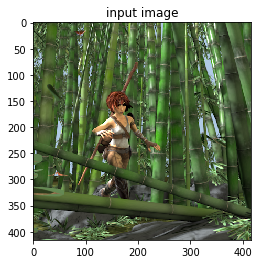

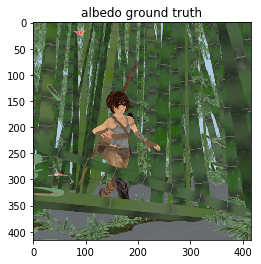

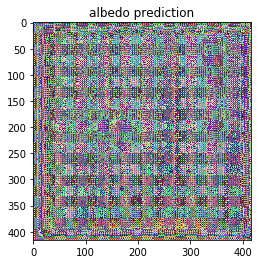

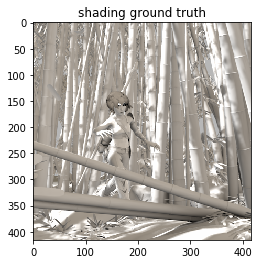

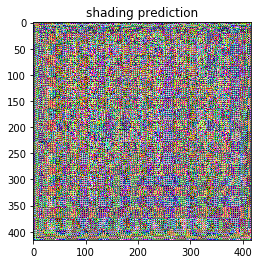

In [14]:
with tf.Session() as sess:
    # Restore variables from disk.
    meta_graph.restore(sess, checkpoint_path)
    
    # import one image:
    img, alb, shad, invalid = iq.next_batch(deq=df_test.iloc[[0]], 
                                            shape=IMAGE_SHAPE, 
                                            is_flip=False, 
                                            is_rotated=False,
                                            norm=True)
    
    feed_dict = {x: img, 
                 y_albedo_label: alb,
                 y_shading_label: shad, 
                 training: False}

    pred_alb, pred_shad = sess.run([y_albedo_pred, y_shading_pred],
                                   feed_dict)
    
################################################################################

#print(f'path to (raw) image: {path_te}')
plt_help.plot_images(images=[img.reshape(IMAGE_SHAPE), 
                             alb.reshape(IMAGE_SHAPE), 
                             pred_alb.reshape(IMAGE_SHAPE), 
                             shad.reshape(IMAGE_SHAPE), 
                             pred_shad.reshape(IMAGE_SHAPE)],
                     titles=['input image', 
                             'albedo ground truth', 
                             'albedo prediction', 
                             'shading ground truth', 
                             'shading prediction'])

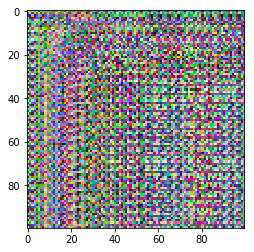

In [15]:
img_inspect = pred_alb.reshape(IMAGE_SHAPE)
plt.imshow(img_inspect[:100,:100,:])

In [16]:
print(pred_alb.max())
print(pred_alb.min())
print(pred_shad.max())
print(pred_shad.min())

5.07384
-4.93823
8.94871
-5.5234


In [17]:
# !tensorboard --logdir ./logs/camp/2